In [42]:
# The autoreload extension will automatically load in new code as you edit files, 
# so you don't need to restart the kernel every time
%load_ext autoreload
%autoreload 2

import numpy as np
from P1_astar import AStar
from P2_rrt import *
from P3_traj_planning import compute_smoothed_traj, modify_traj_with_limits, SwitchingController
import matplotlib.pyplot as plt
from HW1.P1_differential_flatness import *
from HW1.P2_pose_stabilization import *
from HW1.P3_trajectory_tracking import *
from utils import generate_planning_problem
from HW1.utils import simulate_car_dyn

plt.rcParams['figure.figsize'] = [14, 14] # Change default figure size

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate workspace, start and goal positions

In [13]:
width = 100
height = 100
num_obs = 25
min_size = 5
max_size = 30

occupancy, x_init, x_goal = generate_planning_problem(width, height, num_obs, min_size, max_size)

### Solve A* planning problem

In [14]:
astar = AStar((0, 0), (width, height), x_init, x_goal, occupancy)
if not astar.solve():
    print("No path found")

## Smooth Trajectory Generation
### Trajectory parameters
(Try changing these and see what happens)

In [32]:
V_des = 0.3  # Nominal velocity
alpha = 0.5   # Smoothness parameter
dt = 0.05

### Generate smoothed trajectory

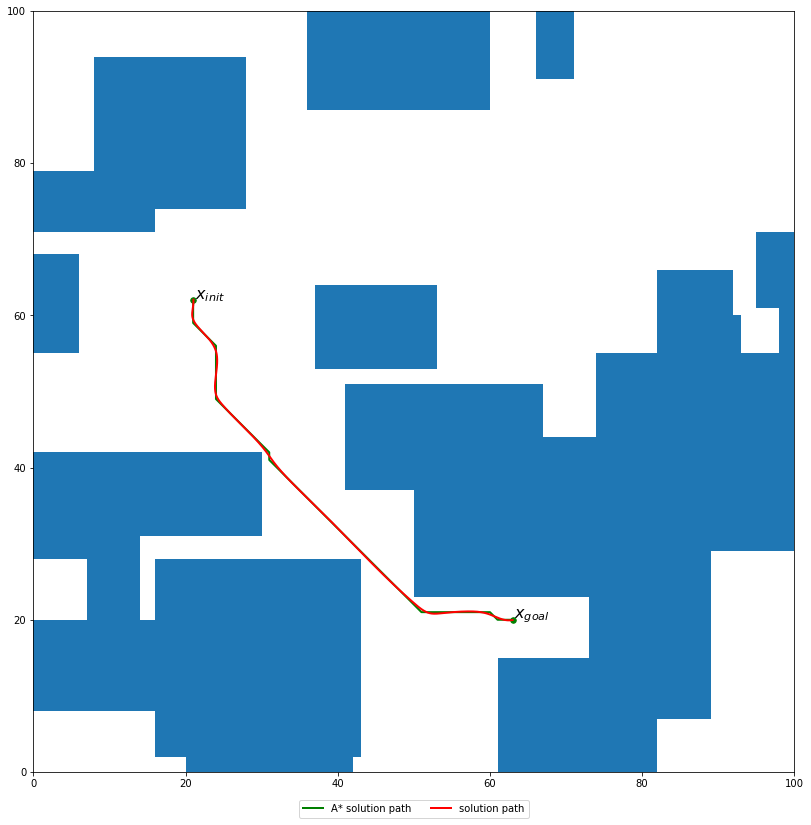

In [33]:
traj_smoothed, t_smoothed = compute_smoothed_traj(astar.path, V_des, alpha, dt)

fig = plt.figure()
astar.plot_path(fig.number)
def plot_traj_smoothed(traj_smoothed):
    plt.plot(traj_smoothed[:,0], traj_smoothed[:,1], color="red", linewidth=2, label="solution path", zorder=10)
plot_traj_smoothed(traj_smoothed)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.03), fancybox=True, ncol=3)
plt.show()

## Control-Feasible Trajectory Generation and Tracking
### Robot control limits

In [34]:
V_max = 0.5 # max speed
om_max = 1 # max rotational speed

### Tracking control gains
Tune these as needed to improve tracking performance.

In [35]:
kpx = 2
kpy = 2
kdx = 2
kdy = 2

### Generate control-feasible trajectory

In [36]:
t_new, V_smooth_scaled, om_smooth_scaled, traj_smooth_scaled = modify_traj_with_limits(traj_smoothed, t_smoothed, V_max, om_max, dt)

### Create trajectory controller and load trajectory

In [37]:
traj_controller = TrajectoryTracker(kpx=kpx, kpy=kpy, kdx=kdx, kdy=kdy, V_max=V_max, om_max=om_max)
traj_controller.load_traj(t_new, traj_smooth_scaled)

### Set simulation input noise
(Try changing this and see what happens)

In [129]:
noise_scale = 0.1

### Simulate closed-loop tracking of smoothed trajectory, compare to open-loop

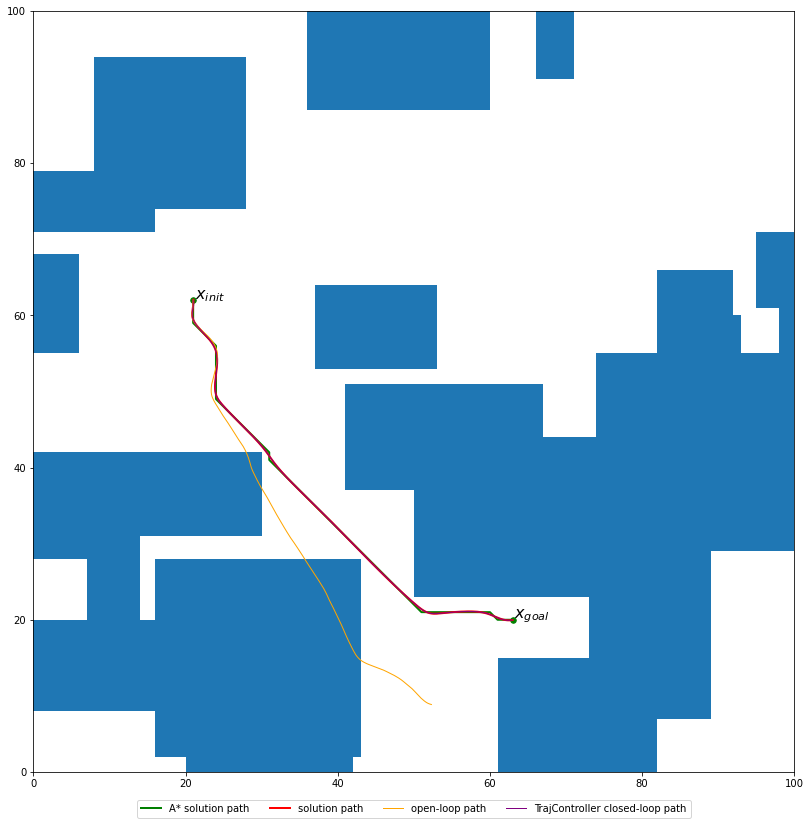

In [130]:
tf_actual = t_new[-1]
times_cl = np.arange(0, tf_actual, dt)
s_0 = State(x=x_init[0], y=x_init[1], V=V_max, th=traj_smooth_scaled[0,2])
s_f = State(x=x_goal[0], y=x_goal[1], V=V_max, th=traj_smooth_scaled[-1,2])

actions_ol = np.stack([V_smooth_scaled, om_smooth_scaled], axis=-1)
states_ol, ctrl_ol = simulate_car_dyn(s_0.x, s_0.y, s_0.th, times_cl, actions=actions_ol, noise_scale=noise_scale)
states_cl, ctrl_cl = simulate_car_dyn(s_0.x, s_0.y, s_0.th, times_cl, controller=traj_controller, noise_scale=noise_scale)

fig = plt.figure()
astar.plot_path(fig.number)
plot_traj_smoothed(traj_smoothed)
def plot_traj_ol(states_ol):
    plt.plot(states_ol[:,0],states_ol[:,1], color="orange", linewidth=1, label="open-loop path", zorder=10)
def plot_traj_cl(states_cl):
    plt.plot(states_cl[:,0], states_cl[:,1], color="purple", linewidth=1, label="TrajController closed-loop path", zorder=10)
plot_traj_ol(states_ol)
plot_traj_cl(states_cl)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.03), fancybox=True, ncol=4)
plt.show()

## Switching from Trajectory Tracking to Pose Stabilization Control
### Zoom in on final pose error

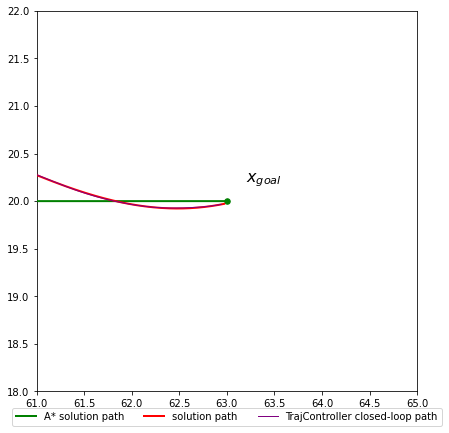

In [131]:
l_window = 4.

fig = plt.figure(figsize=[7,7])
astar.plot_path(fig.number, show_init_label = False)
plot_traj_smoothed(traj_smoothed)
plot_traj_cl(states_cl)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.03), fancybox=True, ncol=3)
plt.axis([x_goal[0]-l_window/2, x_goal[0]+l_window/2, x_goal[1]-l_window/2, x_goal[1]+l_window/2])
plt.show()

### Pose stabilization control gains
Tune these as needed to improve final pose stabilization.

In [132]:
k1 = 1
k2 = 1
k3 = 1

### Create pose controller and load goal pose
Note we use the last value of the smoothed trajectory as the goal heading $\theta$

In [133]:
pose_controller = PoseController(k1, k2, k3, V_max, om_max)
pose_controller.load_goal(x_goal[0], x_goal[1], traj_smooth_scaled[-1,2])

### Time before trajectory-tracking completion to switch to pose stabilization
Try changing this!

In [134]:
t_before_switch = 5.0

### Create switching controller and compare performance

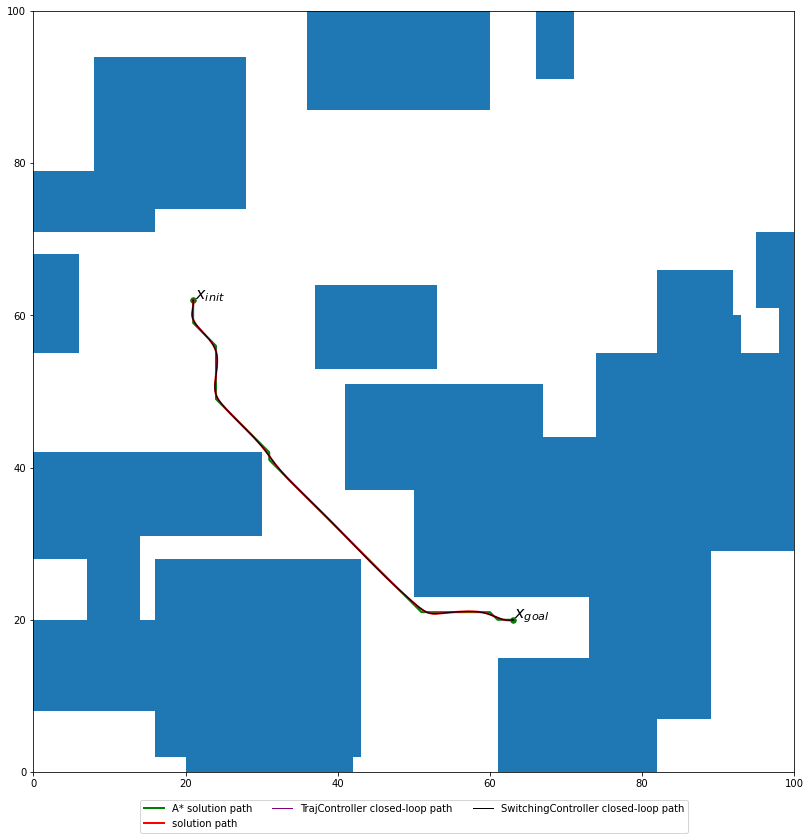

In [135]:
switching_controller = SwitchingController(traj_controller, pose_controller, t_before_switch)

t_extend = 60.0 # Extra time to simulate after the end of the nominal trajectory
times_cl_extended = np.arange(0, tf_actual+t_extend, dt)
states_cl_sw, ctrl_cl_sw = simulate_car_dyn(s_0.x, s_0.y, s_0.th, times_cl_extended, controller=switching_controller, noise_scale=noise_scale)

fig = plt.figure()
astar.plot_path(fig.number)
plot_traj_smoothed(traj_smoothed)
plot_traj_cl(states_cl)
def plot_traj_cl_sw(states_cl_sw):
    plt.plot(states_cl_sw[:,0], states_cl_sw[:,1], color="black", linewidth=1, label="SwitchingController closed-loop path", zorder=10)
plot_traj_cl_sw(states_cl_sw)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.03), fancybox=True, ncol=3)
plt.show()

### Zoom in on final pose

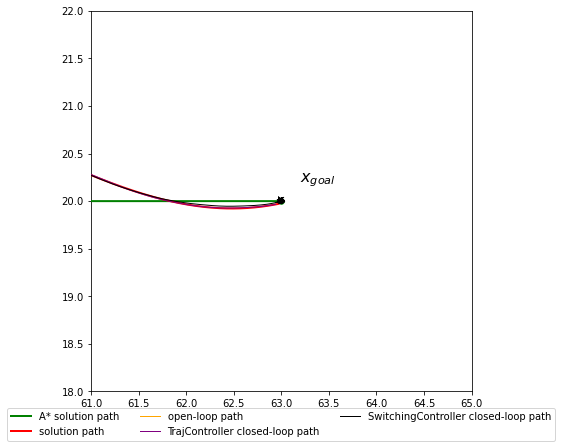

In [136]:
l_window = 4.

fig = plt.figure(figsize=[7,7])
astar.plot_path(fig.number, show_init_label = False)
plot_traj_smoothed(traj_smoothed)
plot_traj_ol(states_ol)
plot_traj_cl(states_cl)
plot_traj_cl_sw(states_cl_sw)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.03), fancybox=True, ncol=3)
plt.axis([x_goal[0]-l_window/2, x_goal[0]+l_window/2, x_goal[1]-l_window/2, x_goal[1]+l_window/2])
plt.show()

### Plot final sequence of states
To see just how well we're able to arrive at the target point (and to assist in choosing values for the pose stabilization controller gains $k_1,k_2,k_3$), we plot the error in $x$ and $y$ for both the tracking controller and the switching controller at the end of the trajectory.

Text(0, 0.5, 'y error (m)')

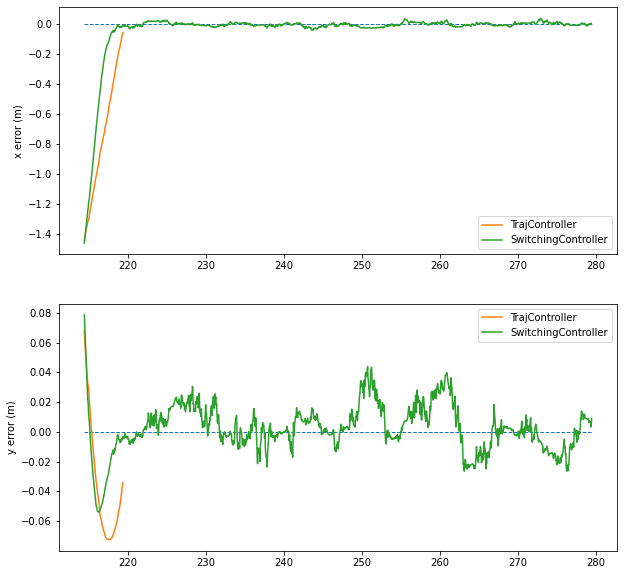

In [137]:
T = len(times_cl) - int(t_before_switch/dt)
fig = plt.figure(figsize=[10,10])
plt.subplot(2,1,1)
plt.plot([times_cl_extended[T], times_cl_extended[-1]], [0,0], linestyle='--', linewidth=1)
plt.plot(times_cl[T:], states_cl[T:,0] - x_goal[0], label='TrajController')
plt.plot(times_cl_extended[T:], states_cl_sw[T:,0] - x_goal[0], label='SwitchingController')
plt.legend()
plt.ylabel("x error (m)")
plt.subplot(2,1,2)
plt.plot([times_cl_extended[T], times_cl_extended[-1]], [0,0], linestyle='--', linewidth=1)
plt.plot(times_cl[T:], states_cl[T:,1] - x_goal[1], label='TrajController')
plt.plot(times_cl_extended[T:], states_cl_sw[T:,1] - x_goal[1], label='SwitchingController')
plt.legend()
plt.ylabel("y error (m)")